## Adversarial Patch for Object Detection

__Description__:

This notebook demonstrates how to perform adversarial patch attacks on object detection models using HEART and MAITE. For the purposes of this demonstration, DeTR we be the object detection model of choice and a variety of images from the COCO data set will be used for executing detection and attack.

__Intended Audience__:

Advanced T&E Users

## Contents:
1. Notebook imports and utility functions
2. Define the object detector
3. Prepare images and detect objects
4. Define the patch attack
5. Execute the attack
6. Conclusion
7. Next Steps

## 1. Notebook imports

In [1]:
import numpy as np
from torchvision.transforms import transforms
from heart_library.estimators.object_detection import JaticPyTorchObjectDetector
from heart_library.attacks.attack import JaticAttack

from art.attacks.evasion import AdversarialPatchPyTorch
from datasets import load_dataset
import torch

import cv2
import matplotlib.pyplot as plt

%matplotlib inline

coco_labels = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

yolo_labels = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 
        'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 
        'teddy bear', 'hair drier', 'toothbrush']

def extract_predictions(predictions_, conf_thresh, labels=coco_labels):
    # Get the predicted class
    predictions_class = [labels[i] for i in list(predictions_.labels)]
    #  print("\npredicted classes:", predictions_class)
    if len(predictions_class) < 1:
        return [], [], []
    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_.boxes)]

    # Get the predicted prediction score
    predictions_score = list(predictions_.scores)
    # print("predicted score:", predictions_score)

    # Get a list of index with score greater than threshold
    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t  # [-1] #indices where score over threshold
    else:
        # no predictions esxceeding threshold
        return [], [], []
    # predictions in score order
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores


def plot_image_with_boxes(img, boxes, pred_cls, title):
    img = (img*255).astype(np.uint8)
    text_size = 2
    text_th = 2
    rect_th = 2

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        # Write the prediction class
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img, interpolation="nearest")
    # plt.show()

## 2. Define the object detector
The following cell:
- initialises the object detector which supports the MAITE functionality

In [2]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225] 
preprocessing=(MEAN, STD)

detector = JaticPyTorchObjectDetector(model_type="detr_resnet50",
                                      device_type='cpu',
                                    input_shape=(3, 800, 800),
                                    clip_values=(0, 1), 
                                    attack_losses=( "loss_ce",
                                        "loss_bbox",
                                        "loss_giou",), 
                                    preprocessing=preprocessing)

Using cache found in /Users/kieranfraser/.cache/torch/hub/facebookresearch_detr_main


## 3. Prepare images and detect objects
The following cell:
- Downloads and transforms a number of images from the COCO dataset for demonstration purposes
- The DeTR model requires images to be of shape 800x800 and pixel values ranging from 0-1
- Output predictions are returned when the detector is executed
- The utility functions are used to draw the detections which are above a specified threshold on the images along with their predicted label

Resolving data files:   0%|          | 0/202 [00:00<?, ?it/s]

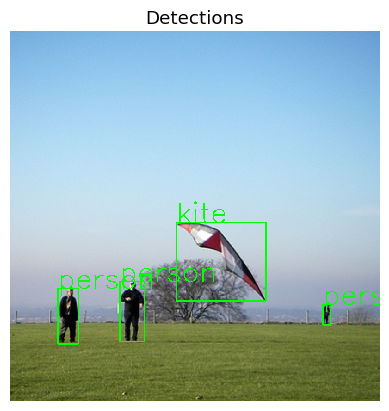

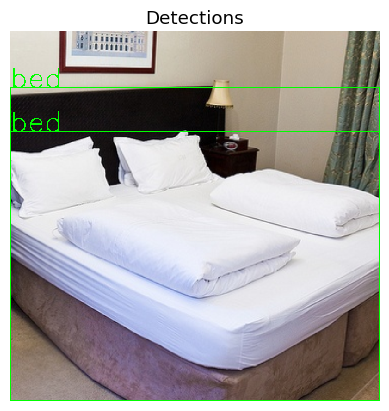

In [3]:
data = load_dataset("guydada/quickstart-coco", split="train[20:30]")

preprocess = transforms.Compose([
    transforms.Resize(800),
    transforms.CenterCrop(800),
    transforms.ToTensor()
])

data = data.map(lambda x: {"image": preprocess(x["image"]), "label": None})
sample_data = torch.utils.data.Subset(data, list(range(2)))

detections = detector(sample_data)

for i in range(len(sample_data)):
    preds_orig = extract_predictions(detections[i], 0.5)
    img = np.asarray(sample_data[i]["image"]).transpose(1,2,0)
    plot_image_with_boxes(img=img.copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

## 4. Define the patch attack
The following cell:
- defines hyperparameters for an adversarial patch attack
- wraps the patch attack in the '''JaticAttack''' so it conforms to MAITE operations

In [4]:
rotation_max=0.0
scale_min=0.5
scale_max=1.0
distortion_scale_max=0.0
learning_rate=1.99
max_iter=50
batch_size=16
patch_shape=(3, 500, 500)
patch_location=(200,200)
patch_type="circle"
optimizer="Adam"

attack = JaticAttack(
    AdversarialPatchPyTorch(detector, rotation_max=rotation_max, 
                      scale_min=scale_min, scale_max=scale_max, optimizer=optimizer, distortion_scale_max=distortion_scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size, patch_location=patch_location,
                      patch_shape=patch_shape, patch_type=patch_type, verbose=True, targeted=True)
    )

## 5. Execute the attack
The following cell:
- first creates a list of dictionaries, one for each image which contain the predicted boxes, scores and labels from the object detector
- these predictions are then filtered, to include only the detections which have a score higher than a threshold (40% confidence is selected here)
- a data dictionary is created with keys:
    - 'image': which contains all the images except the last (the image of elephants)
    - 'label': which contains the predicted (and filtered) detections for only the last image (of elephants), repeated for every image we have in added
- this is because we have defined a targeted attack and want the patch to detect 'elephants' no matter what image we are passing

In [5]:
from typing import Tuple, Dict, Any
from copy import deepcopy
from maite.protocols.object_detection import Dataset as od_dataset

class TargetedImageDataset:
    
    metadata = {"id": "example"}
    
    def __init__(self, images, groundtruth, target_label, threshold=0.5):
        self.images = images
        self.groundtruth = groundtruth
        self.target_label = target_label
        self.threshold = threshold
        
    def __len__(self)->int:
        return len(self.data)
    
    def __getitem__(self, ind: int) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
        image = self.images.__getitem__(ind)["image"]
        targeted_detection = self.groundtruth[ind]
        targeted_detection.boxes = targeted_detection.boxes[targeted_detection.scores>self.threshold]
        targeted_detection.scores = np.asarray([1.0]*len(targeted_detection.boxes))
        targeted_detection.labels = [self.target_label]*len(targeted_detection.boxes)
        return (image, targeted_detection, {})
    
targeted_data = TargetedImageDataset(data, deepcopy(detections), 14)

assert isinstance(targeted_data, od_dataset)

targeted_data = torch.utils.data.Subset(targeted_data, list(range(1)))

In [6]:
adv_images, _, metadata = attack(targeted_data)

Adversarial Patch PyTorch:   0%|          | 0/50 [00:00<?, ?it/s]

## 6. Conclusion
The following cell:
- draws the predicted detections from the adversarial images
- note that elephants now appear as detected objects in the images with the patch applied indicating a successful targeted attack

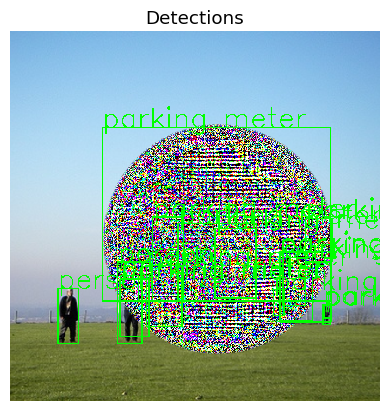

In [7]:
adv_detections = detector(adv_images)
for i in range(len(adv_detections)): 
    preds_orig = extract_predictions(adv_detections[i], 0.2)
    plot_image_with_boxes(img=adv_images[i].transpose(1,2,0).copy(),
                          boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

## DPatch
Example of launching a black-box patch attack, DPatch, against a Faster RCNN object detector

In [8]:
from heart_library.estimators.object_detection.pytorch import JaticPyTorchObjectDetector
import requests

# load the COCO labels for Faster RCNN
coco_label_url = "https://gist.githubusercontent.com/tersekmatija/9d00c4683d52d94cf348acae29e8db1a/raw/8d1b042e7dd6061c760422f51e8e8488c6ad68c7/coco-labels-91.txt"
response = requests.get(coco_label_url)
data = response.text
coco_labels = ['background']  + data.splitlines()

def plot_image_with_boxes(img, boxes, pred_cls, title):
    img = (img).astype(np.uint8)
    text_size = 2
    text_th = 2
    rect_th = 2

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        # Write the prediction class
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img, interpolation="nearest")

#### Define the Faster RCNN detector
- note that this detector takes input images of size 640x640
- all attack losses are made available to the attack

In [9]:
detector = JaticPyTorchObjectDetector(model_type="fasterrcnn_mobilenet_v3_large_320_fpn", input_shape=(3, 640, 640),
                                      clip_values=(0,255),
                                      attack_losses=("loss_classifier",
                                                    "loss_box_reg",
                                                    "loss_objectness",
                                                    "loss_rpn_box_reg",))

#### Load the dataset and test detections
- Apply the transform to resize the image to 640x640 expected by Faster RCNN
- Adjust pixel range to 0-255 for faster convergence

Resolving data files:   0%|          | 0/202 [00:00<?, ?it/s]

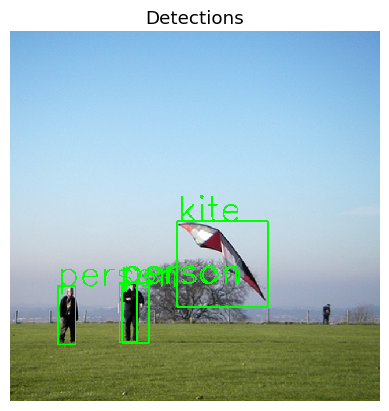

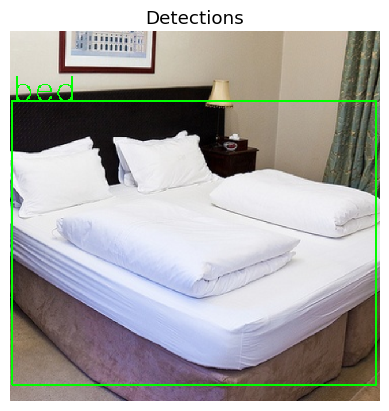

In [10]:
data = load_dataset("guydada/quickstart-coco", split="train[20:30]")

preprocess = transforms.Compose([
    transforms.Resize(640),
    transforms.CenterCrop(640),
    transforms.ToTensor()
])

data = data.map(lambda x: {"image": preprocess(x["image"])*255, "label": None})
sample_data = torch.utils.data.Subset(data, list(range(2)))

detections = detector(sample_data)

for i in range(len(sample_data)):
    preds_orig = extract_predictions(detections[i], 0.5)
    img = np.asarray(sample_data[i]["image"]).transpose(1,2,0)
    plot_image_with_boxes(img=img.copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

#### Create a targeted dataset, define the attack and execute
- A targeted dataset is created which filters detections to be higher than a threshold of 0.8. The label "parking meter" is also used as the target class (14).
- The RobustDPatch attack is defined, with fixed patch location, and default transformations
- The attack is wrapped in the JaticAttack class and executed for 50 iterations

In [11]:
from art.attacks.evasion import RobustDPatch
from typing import Tuple, Dict, Any
from copy import deepcopy

class TargetedImageDataset:
    
    metadata = {"id": "example"}
    
    def __init__(self, images, groundtruth, target_label, threshold=0.5):
        self.images = images
        self.groundtruth = groundtruth
        self.target_label = target_label
        self.threshold = threshold
        
    def __len__(self)->int:
        return len(self.data)
    
    def __getitem__(self, ind: int) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
        image = self.images.__getitem__(ind)["image"]
        targeted_detection = self.groundtruth[ind]
        targeted_detection.boxes = targeted_detection.boxes[targeted_detection.scores>self.threshold]
        targeted_detection.scores = np.asarray([1.0]*len(targeted_detection.boxes))
        targeted_detection.labels = [self.target_label]*len(targeted_detection.boxes)
        return (image, targeted_detection, {})
    
targeted_data = TargetedImageDataset(data, deepcopy(detections), 14, 0.8)

assert isinstance(targeted_data, od_dataset)

targeted_data = torch.utils.data.Subset(targeted_data, list(range(1)))

evasion_attack = RobustDPatch(
    detector,
    patch_shape=(3, 300, 300),
    patch_location=(100, 100),
    crop_range=[0,0],
    brightness_range=[1.0, 1.0],
    rotation_weights=[1, 0, 0, 0],
    sample_size=1,
    learning_rate=1.99,
    max_iter=50,
    verbose=True,
    targeted=True
)
attack = JaticAttack(evasion_attack, norm=2)

adv_images, y, metadata = attack(targeted_data)

RobustDPatch iteration:   0%|          | 0/50 [00:00<?, ?it/s]

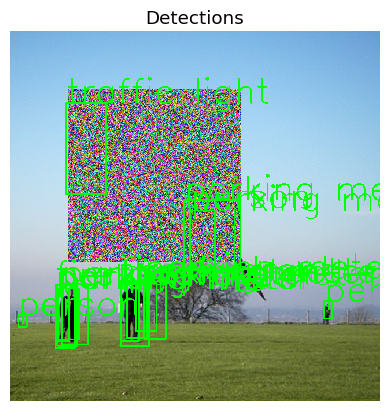

In [12]:
adv_detections = detector(adv_images)
for i in range(len(adv_detections)): 
    preds_orig = extract_predictions(adv_detections[i], 0.01)
    plot_image_with_boxes(img=adv_images[i].transpose(1,2,0).copy(),
                          boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

In [13]:
for i in range(5):
    label = preds_orig[0][i]
    score = preds_orig[2][i]
    print(f"detected class: {label}\nconfidence: {score}\n-----")

detected class: parking meter
confidence: 0.8672298789024353
-----
detected class: parking meter
confidence: 0.7362030744552612
-----
detected class: parking meter
confidence: 0.4396398365497589
-----
detected class: parking meter
confidence: 0.3205648362636566
-----
detected class: parking meter
confidence: 0.24467085301876068
-----


#### Example with YOLO

In [14]:
data = load_dataset("guydada/quickstart-coco", split="train[20:30]")

preprocess = transforms.Compose([
    transforms.Resize(1280),
    transforms.CenterCrop(1280),
    transforms.ToTensor()
])

data = data.map(lambda x: {"image": preprocess(x["image"])*255, "label": None})
sample_data = torch.utils.data.Subset(data, list(range(2)))

Resolving data files:   0%|          | 0/202 [00:00<?, ?it/s]

In [15]:
detector = JaticPyTorchObjectDetector(model_type="yolov5n6", input_shape=(3, 1280, 1280), attack_losses=("loss_total",),
                                      clip_values=(0,255))

detections = detector(sample_data)

targeted_data = TargetedImageDataset(data, deepcopy(detections), 12, 0.7)
targeted_data = torch.utils.data.Subset(targeted_data, list(range(1)))

evasion_attack = RobustDPatch(
    detector,
    patch_shape=(3, 300, 300),
    patch_location=(100, 100),
    crop_range=[0,0],
    brightness_range=[1.0, 1.0],
    rotation_weights=[1, 0, 0, 0],
    sample_size=1,
    learning_rate=1.99,
    max_iter=100,
    verbose=True,
    targeted=True
)
attack = JaticAttack(evasion_attack, norm=2)

adv_images, y, metadata = attack(targeted_data)

RobustDPatch iteration:   0%|          | 0/100 [00:00<?, ?it/s]

detected class: parking meter
confidence: 0.9145057797431946
-----
detected class: person
confidence: 0.8125017285346985
-----
detected class: parking meter
confidence: 0.8395868539810181
-----
detected class: parking meter
confidence: 0.9065982699394226
-----
detected class: person
confidence: 0.8019943237304688
-----


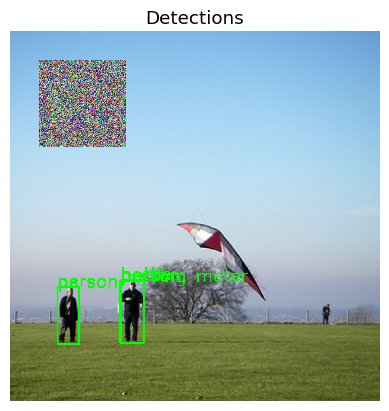

In [17]:
adv_detections = detector(adv_images)
for i in range(len(adv_detections)): 
    preds_orig = extract_predictions(adv_detections[i], 0.7, yolo_labels)
    plot_image_with_boxes(img=adv_images[i].transpose(1,2,0).copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")
    
for i in range(5):
    label = preds_orig[0][i]
    score = preds_orig[2][i]
    print(f"detected class: {label}\nconfidence: {score}\n-----")

## 7. Next Steps
- Swap in your own dataset and apply a patch attack to identify vulnerabilities
- Experiment with the hyperparameters of the adversarial attack
    - try changing attributes of the patch size, shape and location
    - what happens when a patch overlaps with an object or is further removed?
    - is the patch easily identifiable in the image?